# WATER BAG TIME SERIE CLASSIFICATION - Prediction Range Evaluation

---
## Define Functions

#### Change project root directory

In [1]:
cd ../

C:\Users\luisr\Desktop\Repositories\Data Science Projects\Hackaton COR IV - Centro de Operações do RJ\ACELERAÇÃO


#### Import modules and libraries

In [42]:
import os, json, pandas as pd, numpy as np, pickle
import matplotlib.pyplot as plt, seaborn as sns; sns.set()
from IPython.display import clear_output as co

#### Group related split, evaluation and probability methods (Authoral)
from Modulos.imbalanced_selection import (
    groupConsecutiveFlags, MinorityGroupSplitUndersample,
    group_metrics, scoring, cross_val_predict_proba
)
from Modulos.probability import (
    predict_proba, scale_proba, clf_score, precision_recall_plot,
    groups_windows, window_prob, multi_window_prob
)

#### Preprocessing & machine learning modules
from sklearn.preprocessing import StandardScaler as ss, MinMaxScaler as mms, LabelEncoder
from sklearn.model_selection import cross_validate, TimeSeriesSplit
from sklearn.compose import ColumnTransformer
# from sklearn.feature_selection import SelectFromModel, SelectKBest
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils import all_estimators
classifiers = dict(all_estimators('classifier'))

## Utility Funcitons

In [3]:
def target_params_evaluation(Yi, X, target_id, params, pipe, sel_thresh=0.5):

    scrs = []
    for i, param in enumerate(params):
        co(wait=True); print(f'{i+1}/{len(params)} shift values evaluated.')

        ### Target variable
        
        Y, groups, y_cnt = select_target(Yi, X, target_id, **param)

        # Target validation split
        yt = Y.loc[xt.index]
        ye = Y.loc[xe.index]
        groups_train = groups.loc[xt.index]
        groups_eval = groups.loc[xe.index]

        ### Fit and predict with model pipeline

        # Fit pipeline
        pipe.fit(xt, yt)

        # Predict Probability
        yprob = predict_proba(pipe, xe)
        # yprob = scale_proba(yprob, 0.5, limit=None)

        ### Prediction evaluation

        grp_curve = group_metrics.group_precision_recall_curve(ye, yprob, groups_eval, num=50)
        scr_grp = grp_curve[sel_thresh:].iloc[0]
        scr = clf_score(ye, yprob, sel_thresh).rename(columns={'f1-score': 'f1'})

        scr = pd.concat([scr.loc['1.0'].add_suffix('-1'), scr_grp], axis=0)
        for key in param.keys():
            scr[key] = param[key]
        scrs.append(scr)

    scrs = pd.concat(scrs, axis=1).T
    return scrs

---
## Load & Preprocess Data

In [4]:
from Modulos.waterbags import waterbag_project, custom_preprocessing, select_target

project = waterbag_project(time_serie='clusters', freq='upsample', load_waterbags=True, time_features=True)

data = project.data
Yi = project.time_serie
waterbags = project.waterbags

# Sample groups names per group label
target_names = waterbags.groupby(['sublabel', 'main_route']).first().index.to_frame().set_index('sublabel').to_dict()['main_route']

# Drop specific columns from trining dataset
out_time = ['index', 'year', 'date']
out_stations = ['A652', 'A654']
out_inmet = [col for col in data if np.any([station in col for station in out_stations])]

out_cols = out_time + out_inmet
data.drop(out_cols, axis=1, inplace=True)

print('Dataset shape:', data.shape)

C:\Users\luisr\Desktop\Repositories\Data Science Projects\Hackaton COR IV - Centro de Operações do RJ\ACELERAÇÃO\Modulos\waterbags.py:63: FutureWarning: pad is deprecated and will be removed in a future version. Use ffill instead.
  upsample = inmet.resample('15Min').pad()


Dataset shape: (437875, 213)


---
# 1. Preprocessing & Data Transformation

## Preprocessing

In [5]:
label_cols = data.columns[:9]

transform_args = dict(
    label_encode=label_cols,
    interpolate='nearest', fillna='mean'
)

data_encoded, encoder = custom_preprocessing(data.copy(), **transform_args)

Initial shape: (437875, 213)
Label columns encoded: ['month', 'day', 'hour', 'minute', 'time', 'dayofyear', 'weekofyear', 'weekday', 'quarter']
Interpolation: nearest
Fill missing values: mean


### Target rolling proportion

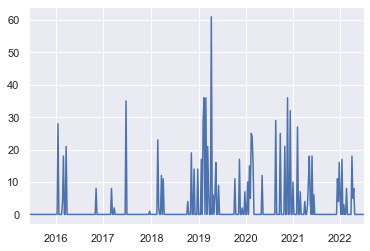

In [6]:
target_id = '1'
periods_ahead = 4

window = 'W'
ax = Yi.loc['2015-06': , target_id].resample(window).sum().plot()

### Feature set

In [40]:
n_splits = 3
train_start, train_end = '2018-07', '2020-06'
eval_start, eval_end = '2020-07', '2022-04'

X = data_encoded[train_start: eval_end].copy()

# Validation split
xt = X[train_start: train_end]
xe = X[eval_start: eval_end]

non_constant = X.columns[[len(X[col].unique()) != 1 for col in X.columns]]

---
# 3. Simple split pipeline evaluation

### Base model

### Selected model pipeline

In [43]:
import sklearn.neural_network as nn

mlp = nn.MLPClassifier

model = mlp(
    (100,), verbose=1, random_state=0, batch_size=200,
    early_stopping=True, validation_fraction=0.1,
    n_iter_no_change=5, tol=0.00012, max_iter=50,
)

seed = 0
train_prct = 0.02
rus = RandomUnderSampler(sampling_strategy=train_prct, random_state=seed)
column_trans = ColumnTransformer([('scale', mms(), non_constant)], remainder='drop')

# Pipeline
pipe = Pipeline([('scale', column_trans), ('under', rus), ('model', model)])

---
# Target shift evaluation

In [44]:
scr_cols = np.array(['precision-1', 'recall-1', 'f1-1'], dtype='object')
stats_cols = ['mean', 'std', 'min', '50%', 'max']

### Period shift evaluation

In [45]:
target_id = '1'
sel_thresh = 0.5
shifts = range(-16, 21, 1)

params = [{'shift': shift, 'periods_ahead': 4} for shift in shifts]
scrs_shift = target_params_evaluation(Yi, X, target_id, params, pipe, sel_thresh=0.5).set_index('shift')

37/37 shift values evaluated.
Target range: 4
Target shift: 4
Iteration 1, loss = 0.08879970
Validation score: 0.981212
Iteration 2, loss = 0.05091843
Validation score: 0.981567
Iteration 3, loss = 0.04560554
Validation score: 0.983339
Iteration 4, loss = 0.04227353
Validation score: 0.983694
Iteration 5, loss = 0.03961412
Validation score: 0.983694
Iteration 6, loss = 0.03806576
Validation score: 0.985112
Iteration 7, loss = 0.03606843
Validation score: 0.984757
Iteration 8, loss = 0.03502091
Validation score: 0.989011
Iteration 9, loss = 0.03356114
Validation score: 0.990074
Iteration 10, loss = 0.03173354
Validation score: 0.990783
Iteration 11, loss = 0.03059884
Validation score: 0.991138
Iteration 12, loss = 0.02930853
Validation score: 0.992201
Iteration 13, loss = 0.02809174
Validation score: 0.992201
Iteration 14, loss = 0.02707176
Validation score: 0.992910
Iteration 15, loss = 0.02682086
Validation score: 0.992556
Iteration 16, loss = 0.02529692
Validation score: 0.993265
Ite

### Shift value scores

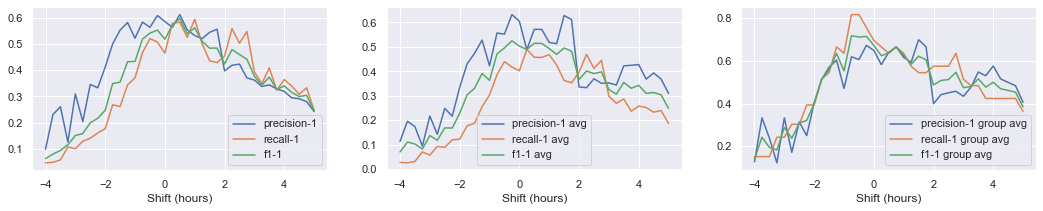

In [46]:
scrs_shift['Shift (hours)'] = scrs_shift.index / 4

fig, ax = plt.subplots(1, 3, figsize=(18, 3))
for i, col_type in enumerate(['', ' avg', ' group avg']):
    scrs_shift.set_index('Shift (hours)')[scr_cols + col_type].plot(ax=ax[i])
plt.show()

### Period range evaluation

17/17 shift values evaluated.
Target range: 16
Target shift: 16
Iteration 1, loss = 0.07192342
Validation score: 0.987364
Iteration 2, loss = 0.04670193
Validation score: 0.987562
Iteration 3, loss = 0.04275213
Validation score: 0.989339
Iteration 4, loss = 0.04010215
Validation score: 0.988351
Iteration 5, loss = 0.03825588
Validation score: 0.990128
Iteration 6, loss = 0.03621788
Validation score: 0.991708
Iteration 7, loss = 0.03482692
Validation score: 0.990918
Iteration 8, loss = 0.03343468
Validation score: 0.991510
Iteration 9, loss = 0.03179754
Validation score: 0.992892
Iteration 10, loss = 0.03030519
Validation score: 0.992892
Iteration 11, loss = 0.02905757
Validation score: 0.992892
Iteration 12, loss = 0.02753325
Validation score: 0.992103
Iteration 13, loss = 0.02656769
Validation score: 0.993287
Iteration 14, loss = 0.02542394
Validation score: 0.993287
Iteration 15, loss = 0.02442657
Validation score: 0.993287
Iteration 16, loss = 0.02325040
Validation score: 0.993090
I

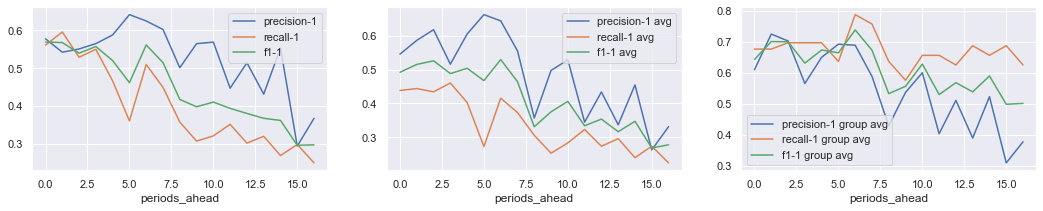

In [48]:
target_id = '1'
sel_thresh = 0.5
periods = [None] + list(range(1, 17, 1))

params = [{'shift': 0, 'periods_ahead': period} for period in periods]
scrs_periods = target_params_evaluation(Yi, X, target_id, params, pipe, sel_thresh=0.5).set_index('periods_ahead')
scrs_periods.index = scrs_periods.index.fillna(0.)

fig, ax = plt.subplots(1, 3, figsize=(18, 3))
for i, col_type in enumerate(['', ' avg', ' group avg']):
    scrs_periods[scr_cols + col_type].plot(ax=ax[i])
plt.show()